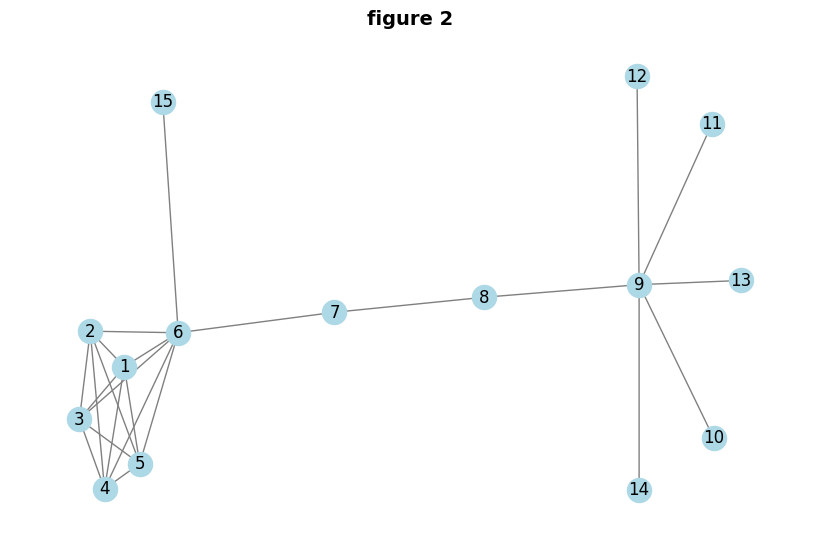

In [ ]:
# Exercise 2: Katz and PageRank on Figure 2 


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1) Build the graph exactly as in Figure 2
G = nx.Graph()
edges = [
    (1,2),(1,3),(1,4),(1,5),(1,6),
    (2,3),(2,4),(2,5),(2,6),
    (3,4),(3,5),(3,6),
    (4,5),(4,6),
    (5,6),
    (6,7),(7,8),(8,9),
    (9,10),(9,11),(9,12),(9,13),(9,14),
    (6,15)
]
G.add_edges_from(edges)

# Draw for sanity check
pos = nx.spring_layout(G, seed=1)
plt.figure(figsize=(8,5))
nx.draw(G,pos,with_labels=True,node_color="lightblue",edge_color="gray")
plt.title("figure 2", fontsize=14, fontweight='bold')
plt.show()





# Part 2(a) Katz centrality

For Katz centrality, consider the following dynamics:

$$
\begin{cases} 
z(t+1) = \frac{(1-\beta)}{\lambda_W}W'z(t) + \beta \mu  \\
z(0) = z_0.
\end{cases}
$$

It is easy to prove that the dynamics converges to the Katz centrality.

The proposed method is iterative (and therefore more efficient than direct method), but it is not distributed. Indeed, to perform the computation, every node needs to know $\lambda_W$, which is a global information on the network.


--- Katz centrality (β=0.15) ---
n 1: 0.118138
n 2: 0.118138
n 3: 0.118138
n 4: 0.118138
n 5: 0.118138
n 6: 0.130079
n 7: 0.044247
n 8: 0.031722
n 9: 0.042813
n10: 0.024305
n11: 0.024305
n12: 0.024305
n13: 0.024305
n14: 0.024305
n15: 0.038930


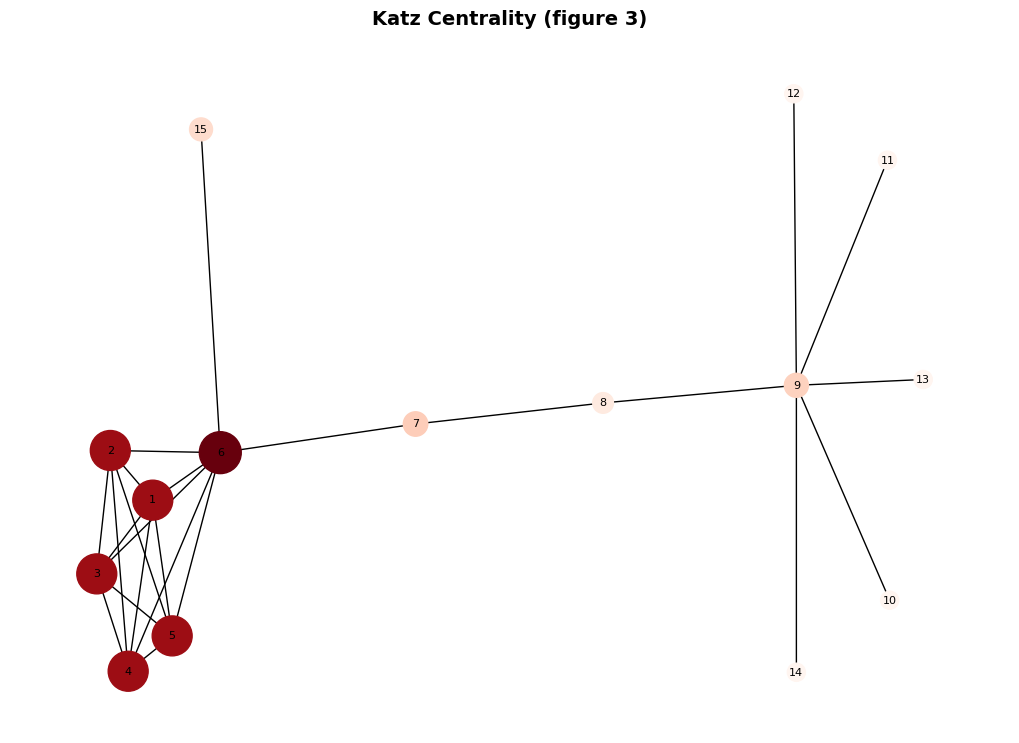

In [ ]:
# --- KATZ CENTRALITY (β = 0.15) ---
W = nx.adjacency_matrix(G)
W = W.toarray()

# compute the largest eigenvalue of W
w,v = np.linalg.eig(W)
w = w.real

lambda_max = max(w)

n = G.number_of_nodes()
beta = 0.15
mu = np.ones((n,1))/n
z = np.ones((n,1))/n
A = ((1-beta)/lambda_max)*W.T

tol = 1e-5
while True:
    z_new = A @ z + beta*mu
    if np.linalg.norm(z_new-z,1)<tol:
        break
    z=z_new
zk = z_new


# normalize the centrality
zk = zk/sum(zk)
zk = zk.reshape(n)

#printing katz centrality for each node
print("\n--- Katz centrality (β=0.15) ---")
for node,score in zip(sorted(G.nodes()),zk):
    print(f"n{node:2d}: {score:.6f}")


# GRAPH FOR KATZ CENTRALITY
plt.figure(1, figsize=(10,7))
# we draw the graph with same node position "pos" defined above
nx.draw(G,pos,
         with_labels=True,
         nodelist=list(G.nodes()), 
         # node size is proportional to centrality value
         node_size = zk*7000, 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=zk,
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Reds) 

plt.title("Katz Centrality (figure 3)", fontsize=14, fontweight='bold')
plt.show()

# Part 2(b) Distributed algorithm for the computation of Page-rank centrality, with β = 0.15 and uniform intrinsic centrality µ

Consider the dynamics
$$
\begin{cases} 
z(t+1) = (1-\beta)P'z(t) + \beta \mu  \\
z(0) = z_0
\end{cases}
$$

The transient of the dynamics is

$$
\begin{cases}
z(1) = (1-\beta)P'z(0) + \beta \mu\\
z(2) = (1-\beta)^2 (P')^2 z(0) + (1-\beta)P' \beta \mu + \beta \mu\\
\vdots\\
z(t) = (1-\beta)^t (P')^t z(0) + \sum_{i=0}^{t-1} (1-\beta)^i (P')^i \beta \mu
\end{cases}
$$

The first term vanishes as $t \to +\infty$ because $(1-\beta)P'$ is sub-stochastic, while the second term is a geometric sum. The dynamics thus converges to the limit

$$
\lim_{t \to +\infty} z(t) = (\mathbf{I}-(1-\beta) P')^{-1} \beta \mu,
$$

which is the Bonacich centrality of the graph.


**Why we choose distributed method?** The iterative method is more efficient than the direct one as the order of the graph grows, since it does not involve the inversion of a $N \times N$ matrix. The proposed method is **distributed**, i.e., the operations at single node levels do not require a complete knowledge of the network. Each node $i$ updates its state $z_i(t+1)$ by using only local information, i.e., the i-th row of $W$ and the state $z_j(t)$ of nodes $j$ that are adjacent to $j$.
Moreover, the convergence of $z(t)$ to the Bonacich centrality holds for every initial condition $z_0$ and the limit is independent of $z_0$.



--- PageRank (β=0.15) ---
n 1: 0.074680
n 2: 0.074680
n 3: 0.074680
n 4: 0.074680
n 5: 0.074680
n 6: 0.114451
n 7: 0.048611
n 8: 0.058150
n 9: 0.194043
n10: 0.037490
n11: 0.037490
n12: 0.037490
n13: 0.037490
n14: 0.037490
n15: 0.023898
sum(PR)= 1.0


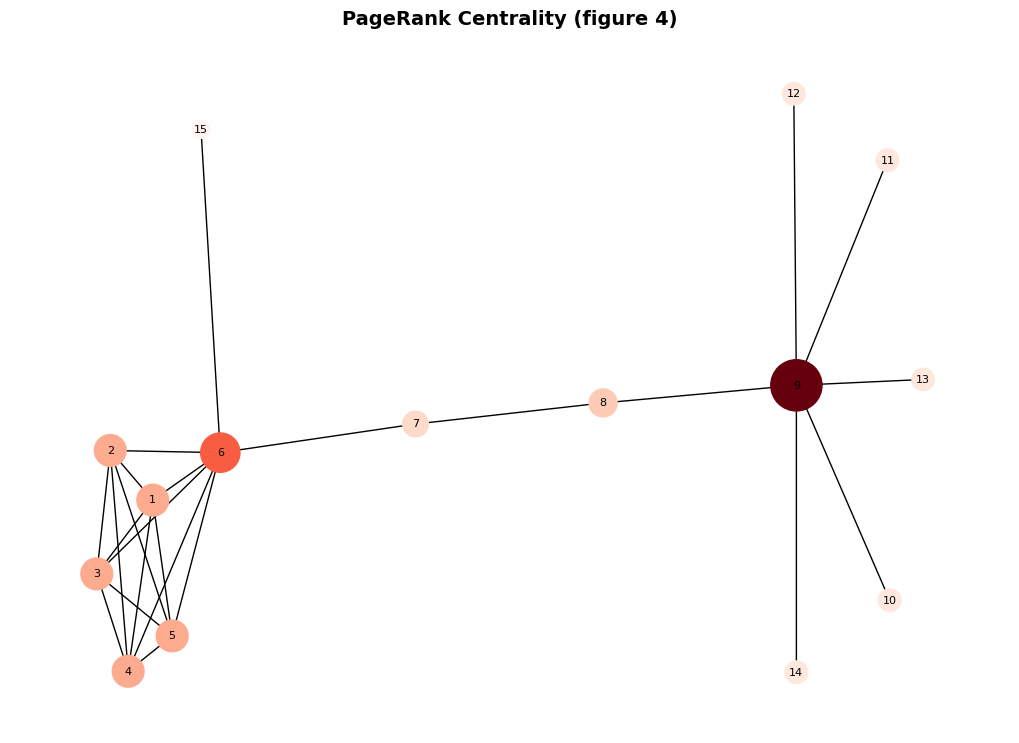

In [ ]:

# --- PAGERANK (Bonacich centrality, β = 0.15) ---

degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

p = np.ones((n,1))/n
tol=1e-5

while True:
    p_new = (1-beta)*(P.T@p)+beta*mu
    if np.linalg.norm(p_new-p,1)<tol:
        break
    p=p_new

pr = p_new

#normalize the centrality
pr = pr/ sum(pr)
pr = pr.reshape(n)

print("\n--- PageRank (β=0.15) ---")
for node,score in zip(sorted(G.nodes()),pr):
    print(f"n{node:2d}: {score:.6f}")
print("sum(PR)=",pr.sum())


#page-rank graph
plt.figure(1, figsize=(10,7))
# we draw the graph with same node position "pos" defined above
nx.draw(G,pos,
         with_labels=True,
         nodelist=list(G.nodes()), 
         # node size is proportional to centrality value
         node_size = pr*7000, 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=pr,
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Reds) 
plt.title("PageRank Centrality (figure 4)", fontsize=14, fontweight='bold')
plt.show()




# Part 2(c): Comparision between nodes n6 and n9:

**In figure 2**, node n6 is the bridge hub that connects:

* the dense cluster of nodes n1-n5 (which are all heavily interconnected), and

* the long chain to the left (through n7 and n8 toward n9).

By contrast, node n9 sits in the center of a small, weakly connected “star” on the left.
It connects only to n8 and to its leaves n10-n14, which themselves have degree 1.
So structurally, n6 is a global hub, while n9 is a local one.

Now as we know, **Katz centrality** counts all walks (short and long), weighting nearby connections more.
In such metrics, nodes surrounded by dense neighborhoods (like n6) dominate because each neighbor can send multiple indirect paths back to n6.
That’s why Katz centrality of n6 >>> n9.

Where as **PageRank** behaves differently: each node shares its importance equally among its outgoing edges.
The five leaves around n9 (n10–n14) each send all their probability to n9, since they have degree 1.
This makes n9 collect a large amount of mass, even though it’s in a sparse region.
That’s why PageRank of n9 >>> n6.

Overall, in this network, Katz centrality highlights global connectivity, ranking n6 highest because it bridges dense and peripheral regions.
While PageRank instead rewards nodes that collect mass from poorly connected neighbors, giving n9 a higher score.
**The difference illustrates how the two measures capture distinct notions of “importance” in a network.**#


In [ ]:
print(f"{'Centrality':<12} | {'Node6':>8} | {'Node9':>8}")
print("-"*36)
print(f"{'Katz':<12} | {0.130079:8.6f} | {0.042813:8.6f}")
print(f"{'PageRank':<12} | {0.114451:8.6f} | {0.194043:8.6f}")


Centrality   |    Node6 |    Node9
------------------------------------
Katz         | 0.130079 | 0.042813
PageRank     | 0.114451 | 0.194043


# PART 2(d)

On the left, the network structure.

On the right, each colored curve shows how PageRank is distributed across all nodes for one β value.

**Interpretation of β:**

β = 0: a pure random walk on the graph (no teleportation).

β → 1: a uniform teleportation process (structure ignored).

Intermediate β: a balance between network structure and uniform randomness.

Thus, as β increases, the network’s structural influence weakens and all nodes’ scores converge toward 
1
/
𝑛
1/n.

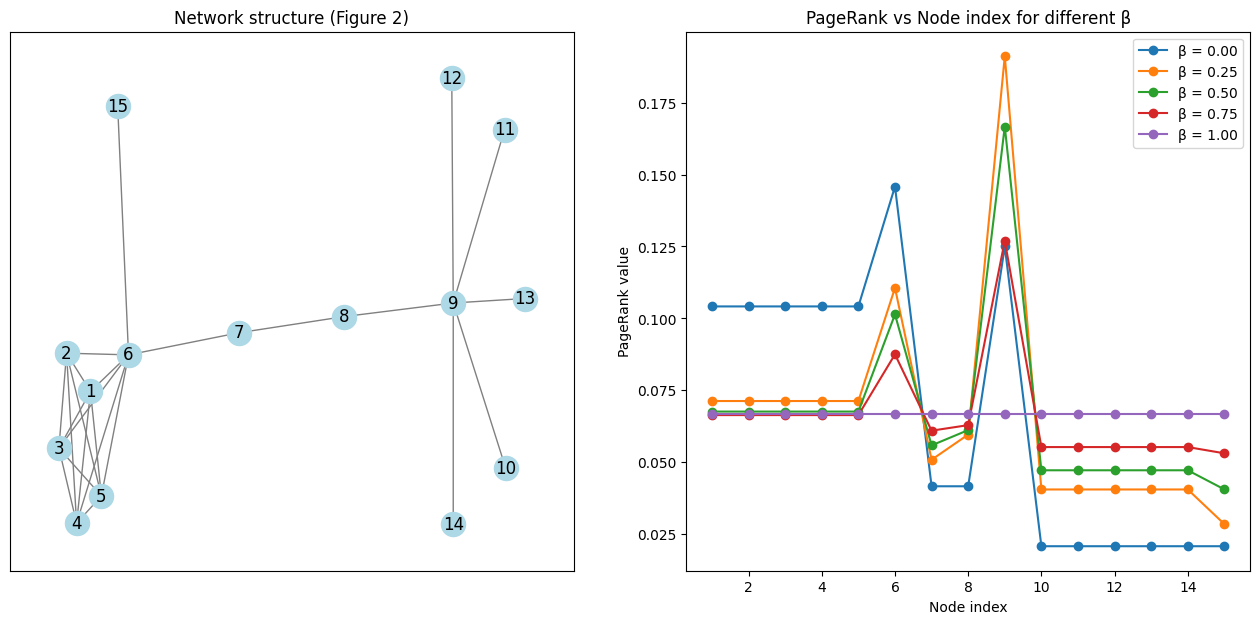

In [ ]:

# (reusing your graph G, transition matrix P, and uniform μ)
betas = [0.0, 0.25, 0.5, 0.75, 1.0]
names = sorted(G.nodes())

def pagerank_power(P, beta, mu, tol=1e-12):
    n = G.number_of_nodes()
    p = np.ones((n,1))/n
    while True:
        p_new = (1-beta)*(P.T @ p) + beta*mu
        if np.linalg.norm(p_new - p, 1) < tol:
            return p_new.reshape(-1,)
        p = p_new

# Compute PageRank for each β and store results
PR_results = []
for b in betas:
    PR_results.append(pagerank_power(P, b, mu))

# --- FIGURE 1: PageRank vs Node index for each β ---
fig = plt.figure(figsize=(16,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# left subplot: network structure
pos = nx.spring_layout(G, seed=1)
nx.draw_networkx(G, pos, ax=ax1, node_color="lightblue", edge_color="gray", with_labels=True)
ax1.set_title("Network structure (Figure 2)")

# right subplot: PageRank values for different β
for b, pr in zip(betas, PR_results):
    ax2.plot(range(1,len(pr)+1), pr, marker='o', label=f"β = {b:.2f}")

ax2.set_xlabel("Node index")
ax2.set_ylabel("PageRank value")
ax2.set_title("PageRank vs Node index for different β")
ax2.legend()
plt.show()


**The curve in figure 5 shows that the difference between PageRank of node 6 & node 9 with respect to differnt values of B doesn't have a monotonic behaviour** because initially, at β = 0, n6 dominates because of its strong structural centrality in the dense core.
As β increases, teleportation allows peripheral nodes such as n9 to gain relative importance, since its many degree-1 neighbors funnel their probability directly to it.
Around β≈0.25 the advantage reverses, making n9 the highest-ranked of the two.
Beyond β≈0.5, the random teleportation smooths all scores, and by β = 1 both nodes have equal rank.
This confirms that increasing β gradually flattens the influence of topology and drives PageRank toward a uniform distribution.

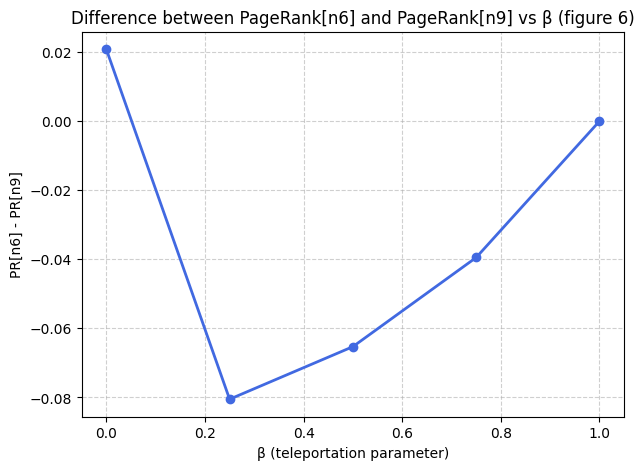

In [ ]:
# --- FIGURE 2: Difference PR[n6] - PR[n9] vs β ---
idx6 = names.index(6)
idx9 = names.index(9)

diffs = [pr[idx6] - pr[idx9] for pr in PR_results]


plt.figure(figsize=(7,5))
plt.plot(betas, diffs, marker='o', linewidth=2, color='royalblue')
plt.xlabel("β (teleportation parameter)")
plt.ylabel("PR[n6] - PR[n9]")
plt.title("Difference between PageRank[n6] and PageRank[n9] vs β (figure 5)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
